In [4]:
cp "drive/MyDrive/DS PROJECTS/APOD_Train.zip" .


In [5]:
cp "drive/MyDrive/DS PROJECTS/APOD_Valid.zip" .


In [6]:
!unzip APOD_Train.zip -d training
!unzip APOD_Valid.zip -d validation

Streaming output truncated to the last 5000 lines.
  inflating: training/__MACOSX/APOD_Train/Fake/._01193.png  
  inflating: training/APOD_Train/Fake/1636371984_00300.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_00300.png  
  inflating: training/APOD_Train/Fake/01178.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._01178.png  
  inflating: training/APOD_Train/Fake/00500.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._00500.png  
  inflating: training/APOD_Train/Fake/1636371984_01787.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_01787.png  
  inflating: training/APOD_Train/Fake/1636371984_00499.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_00499.png  
  inflating: training/APOD_Train/Fake/00514.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._00514.png  
  inflating: training/APOD_Train/Fake/1636371984_01962.png  
  inflating: training/__MACOSX/APOD_Train/Fake/._1636371984_01962.png  
  inflating: training/A

In [2]:
# Import modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE= (256, 256)
BATCH_SIZE = 32
EPOCHS=50

In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training/APOD_Train/",
    shuffle=True,
    image_size = IMAGE_SIZE
)

Found 7000 files belonging to 2 classes.


In [5]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "validation/APOD_Valid/",
    shuffle=True,
    image_size = IMAGE_SIZE
)

Found 2183 files belonging to 2 classes.


In [6]:
class_names = train_dataset.class_names
class_names

['Fake', 'Real']

In [7]:
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1]


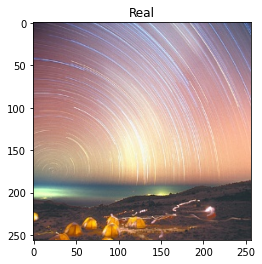

In [8]:
for image_batch, label_batch in train_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.show()

In [9]:
def normalise(image):
  image = (image - image.min()) / (image.max() - image.min()) 
  return image

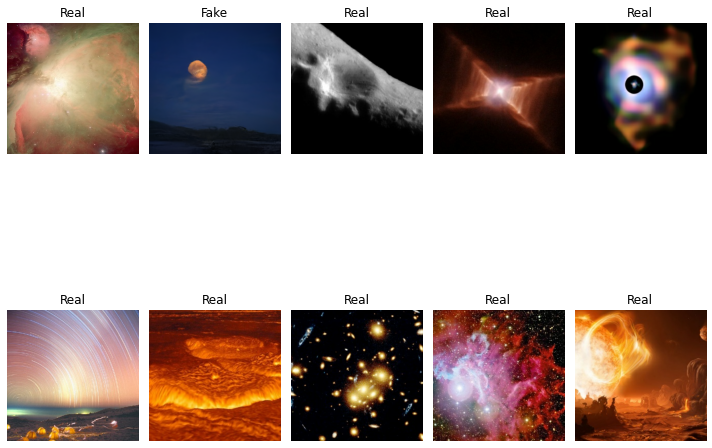

In [10]:
image_batch, label_batch = next(iter(train_dataset))

# visualize 10 images from dataset
plt.figure(figsize=(10,10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = image_batch[i].numpy()
    norm_stacked = normalise(img) 
    plt.imshow(norm_stacked)
    plt.axis("off")
    plt.title(class_names[label_batch[i]])
plt.tight_layout()


In [11]:
def process_image(image, label):
    image = tf.cast(image, tf.float32)
    # image = tf.image.resize(image, [128, 128])
    image = (image / 255.0)
    return image, label

In [12]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment(x, y, seed)
  return image, label

# An augmentation function which will manipulate images randomly on each epoch
def augment(image, label, seed):
    # We are using the "stateless" random functions, so we need to generate
    # random seeds
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_flip_left_right(
        image, seed)
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.image.stateless_random_hue(
        image, 0.1, seed)
    image = tf.image.stateless_random_saturation(
        image, 0.5, 1.0, seed)

    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [13]:
# Create a random generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [14]:
# Training images are parsed with the processing and augmentation functions
train_ds = (
    train_dataset
    .repeat(5)
    .shuffle(1000)
    .map(process_image)
    .map(f)
)

# Validation images are only parsed with the processing function
val_ds = (
    valid_dataset
    .map(process_image)
)

In [15]:
def create_model_optimised():
    model = Sequential([
    layers.Input(shape=IMAGE_SIZE+(3,), name='Input'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 4, padding='same', activation='elu',
                    name='Conv_1'),
    layers.Conv2D(32, 4, padding='same', activation='elu',
                    name='Conv_2'),
    layers.MaxPooling2D(name='Pool_1'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='elu',
                    name='Conv_3'),
    layers.Conv2D(64, 3, padding='same', activation='elu',
                    name='Conv_4'),
    layers.MaxPooling2D(name='Pool_2'),
        layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='elu',
                    name='Conv_5'),
    layers.Conv2D(64, 3, padding='same', activation='elu',
                    name='Conv_6'),
    layers.MaxPooling2D(name='Pool_3'),
    layers.Flatten(name='Flatten'),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dense(2, name='Output')
    ], name='CNN')

    return model

In [16]:
# Create a version of the model and print the summary
model = create_model_optimised()

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 Conv_1 (Conv2D)             (None, 256, 256, 32)      1568      
                                                                 
 Conv_2 (Conv2D)             (None, 256, 256, 32)      16416     
                                                                 
 Pool_1 (MaxPooling2D)       (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 Conv_3 (Conv2D)             (None, 128, 128, 64)      18496   

In [17]:
# Adam optimiser
opt = tf.keras.optimizers.Adam()
# Binary classification loss
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Accuracy metric
metrics = ['accuracy']

# Compile model
model.compile(optimizer=opt,
              loss=loss_obj,
              metrics=metrics)

In [ ]:
# Train the Model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=1)